# Xarray + Cloud OISST (One-Month) Basics & Stats

This notebook demonstrates basic **xarray** operations on a **one-month** subset of a cloud-hosted climate dataset: **NOAA OISST v2.1 daily SST** on AWS Public Datasets (NetCDF files). You'll:
- Discover files for one month on S3 with `fsspec`
- Open them with `xarray.open_mfdataset` (anonymous S3)
- Inspect dataset structure
- Subset in space (and within that month)
- Compute basic stats (mean, std, anomalies relative to the month’s mean)
- Make maps of the month-mean and variability

**Deliverables:** Answer the **🧩 Questions** in the markdown prompts. Fill in the code where indicated by `# TODO`.


In [8]:
import xarray as xr
import fsspec
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10,5)
plt.rcParams['figure.dpi'] = 120


## 1) Open the cloud dataset (NetCDF on AWS, one month)

We'll access **NOAA OISST v2.1 (daily)** in the NOAA CDR bucket on AWS. Files are arranged by **YYYYMM**.

**🧩 Questions**
1. What engine are we using to read NetCDF files from S3?
2. Why do we need `storage_options={'anon': True}`?
3. Inspect dataset attributes: what are the units and long name of `sst`?


In [9]:
yearmonth = "202205"  # TODO: try other months like "201507" or "201909"
prefix = f"noaa-cdr-sea-surface-temp-optimum-interpolation-pds/data/v2.1/avhrr/{yearmonth}/oisst-avhrr-v02r01.*.nc"

fs = fsspec.filesystem("s3", anon=True)
paths = sorted(fs.glob(prefix))
print(f"Found {len(paths)} files for {yearmonth}. Example:", paths[:2])

urls = [f"s3://{p}" for p in paths]

ds = xr.open_mfdataset(
    urls,
    engine="h5netcdf",
    combine="by_coords",
    decode_times=True,
    mask_and_scale=True,
    backend_kwargs={"storage_options": {"anon": True}},
    chunks={"time": 1}
)

ds


Found 31 files for 202205. Example: ['noaa-cdr-sea-surface-temp-optimum-interpolation-pds/data/v2.1/avhrr/202205/oisst-avhrr-v02r01.20220501.nc', 'noaa-cdr-sea-surface-temp-optimum-interpolation-pds/data/v2.1/avhrr/202205/oisst-avhrr-v02r01.20220502.nc']


<xarray.Dataset> Size: 514MB
Dimensions:  (time: 31, zlev: 1, lat: 720, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 248B 2022-05-01T12:00:00 ... 2022-05-31T12...
  * zlev     (zlev) float32 4B 0.0
  * lat      (lat) float32 3kB -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 6kB 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
Data variables:
    sst      (time, zlev, lat, lon) float32 129MB dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>
    anom     (time, zlev, lat, lon) float32 129MB dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>
    err      (time, zlev, lat, lon) float32 129MB dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>
    ice      (time, zlev, lat, lon) float32 129MB dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>
Attributes: (12/37)
    Conventions:                CF-1.6, ACDD-1.3
    title:                      NOAA/NCEI 1/4 Degree Daily Optimum Interpolat...
    references:                 Reynolds, et al.(2007) Daily High-Resolution-...
    source:                     ICOADS, NCEP_GTS, GSFC_ICE, NCEP_ICE, Pathfin...
    id:                         oisst-avhrr-v02r01.20220501.nc
    naming_authority:           gov.noaa.ncei
    ...                         ...
    time_coverage_start:        2022-05-01T00:00:00Z
    time_coverage_end:          2022-05-01T23:59:59Z
    metadata_link:              https://doi.org/10.25921/RE9P-PT57
    ncei_template_version:      NCEI_NetCDF_Grid_Template_v2.0
    comment:                    Data was converted from NetCDF-3 to NetCDF-4 ...
    sensor:                     Thermometer, AVHRR

## 2) Explore coordinates & variables

**🧩 Questions**
1. What are the coordinate names for time and space?
2. What is the shape of `sst`?
3. How are missing values represented?


In [10]:
list(ds.data_vars), list(ds.coords)

(['sst', 'anom', 'err', 'ice'], ['time', 'zlev', 'lat', 'lon'])

## 3) Time & space subsetting

We'll select a **regional box** (e.g., Gulf of Mexico) within this month.

**🧩 Questions**
1. What lon/lat bounds did you choose?
2. How many daily steps are present in this month?


In [11]:
var = "sst"

lon_min, lon_max = -98, -80   # TODO
lat_min, lat_max =  18,  31   # TODO

def to_0360(lon):
    lon = np.asarray(lon)
    out = np.mod(lon, 360.0)
    out[out < 0] += 360.0
    return out

lon_min_0360, lon_max_0360 = to_0360([lon_min, lon_max])

dss = ds.sel(
    lon=slice(lon_min_0360, lon_max_0360),
    lat=slice(lat_min, lat_max)
)

dss[var]


<xarray.DataArray 'sst' (time: 31, zlev: 1, lat: 52, lon: 72)> Size: 464kB
dask.array<getitem, shape=(31, 1, 52, 72), dtype=float32, chunksize=(1, 1, 52, 72), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 248B 2022-05-01T12:00:00 ... 2022-05-31T12...
  * zlev     (zlev) float32 4B 0.0
  * lat      (lat) float32 208B 18.12 18.38 18.62 18.88 ... 30.38 30.62 30.88
  * lon      (lon) float32 288B 262.1 262.4 262.6 262.9 ... 279.4 279.6 279.9
Attributes:
    long_name:  Daily sea surface temperature
    units:      Celsius
    valid_min:  -300
    valid_max:  4500

## 4) Basic statistics

Compute region-wide stats through time and over space **within this month**.

**🧩 Questions**
1. Compute the spatial mean SST time series over your box. What is the monthly average and standard deviation?
2. Compute within-month anomalies (subtract the month-mean). What are the largest positive and negative anomalies?
3. What day had the warmest/coolest region-mean SST?


Month mean SST (°C): 27.224260330200195
Month std SST (°C): 0.497623085975647


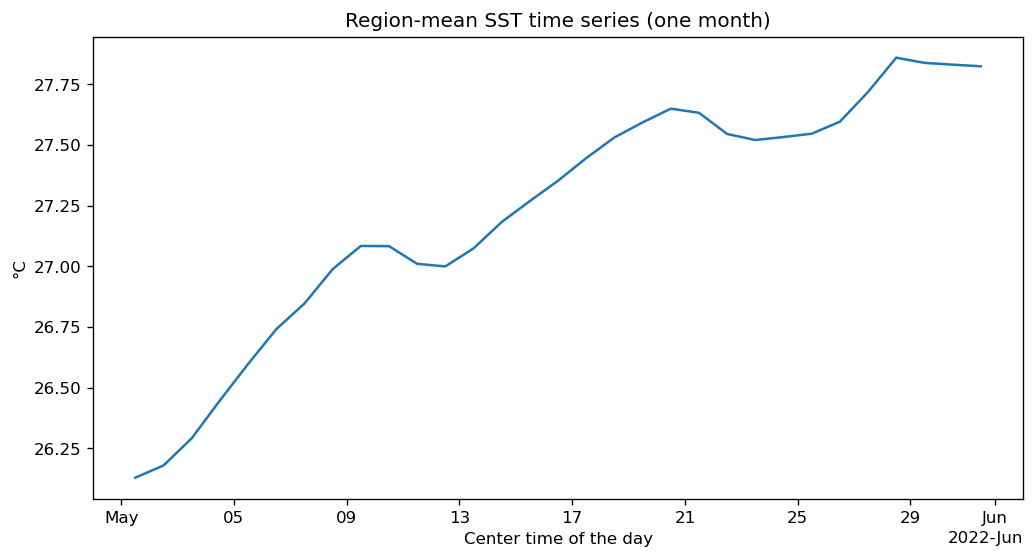

Warmest day: 2022-05-28 27.860130310058594
Coolest day: 2022-05-01 26.129526138305664


/tmp/ipykernel_3790980/4235597154.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Warmest day:', pd.to_datetime(ts.time[imax].values).date(), float(ts.isel(time=imax).values))
/tmp/ipykernel_3790980/4235597154.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Coolest day:', pd.to_datetime(ts.time[imin].values).date(), float(ts.isel(time=imin).values))


In [12]:
ts = dss[var].mean(dim=['lat','lon'])

ts_mean = ts.mean().compute()
ts_std  = ts.std().compute()
print('Month mean SST (°C):', float(ts_mean.values))
print('Month std SST (°C):', float(ts_std.values))

ts.load().plot()
plt.title('Region-mean SST time series (one month)')
plt.ylabel('°C')
plt.show()

imax = int(ts.argmax('time'))
imin = int(ts.argmin('time'))
print('Warmest day:', pd.to_datetime(ts.time[imax].values).date(), float(ts.isel(time=imax).values))
print('Coolest day:', pd.to_datetime(ts.time[imin].values).date(), float(ts.isel(time=imin).values))


Max anomaly (°C): 0.6358713507652283
Min anomaly (°C): -1.0947365760803223


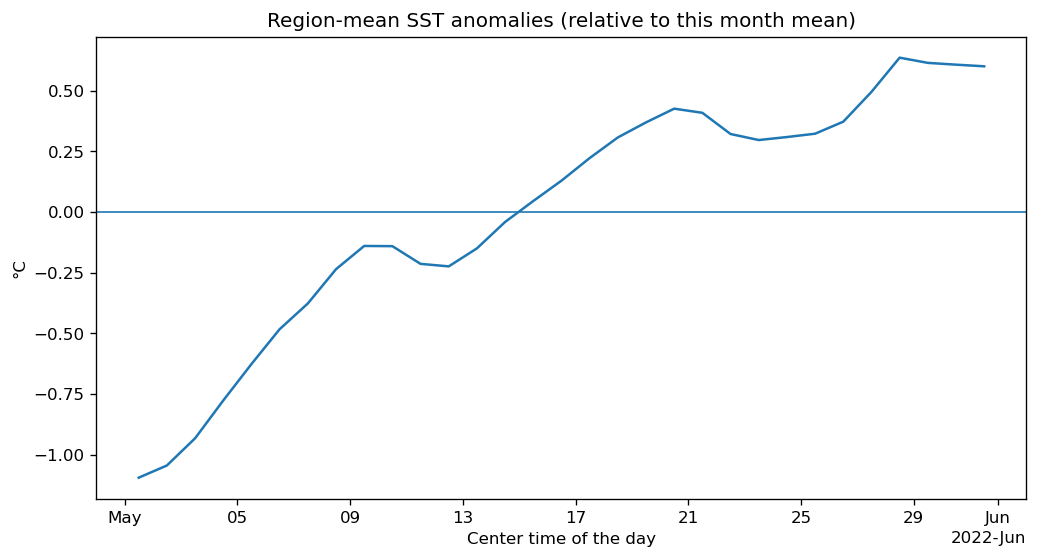

In [13]:
month_mean = dss[var].mean('time')
anom = dss[var] - month_mean

ts_anom = anom.mean(dim=['lat','lon'])
print('Max anomaly (°C):', float(ts_anom.max().compute().values))
print('Min anomaly (°C):', float(ts_anom.min().compute().values))

ts_anom.load().plot()
plt.title('Region-mean SST anomalies (relative to this month mean)')
plt.axhline(0, lw=1)
plt.ylabel('°C')
plt.show()


## 5) Regional maps: month-mean and variability

Make maps of month-mean SST and within-month variability (std and range).

**🧩 Questions**
1. What patterns do you notice?
2. Where is variability strongest?


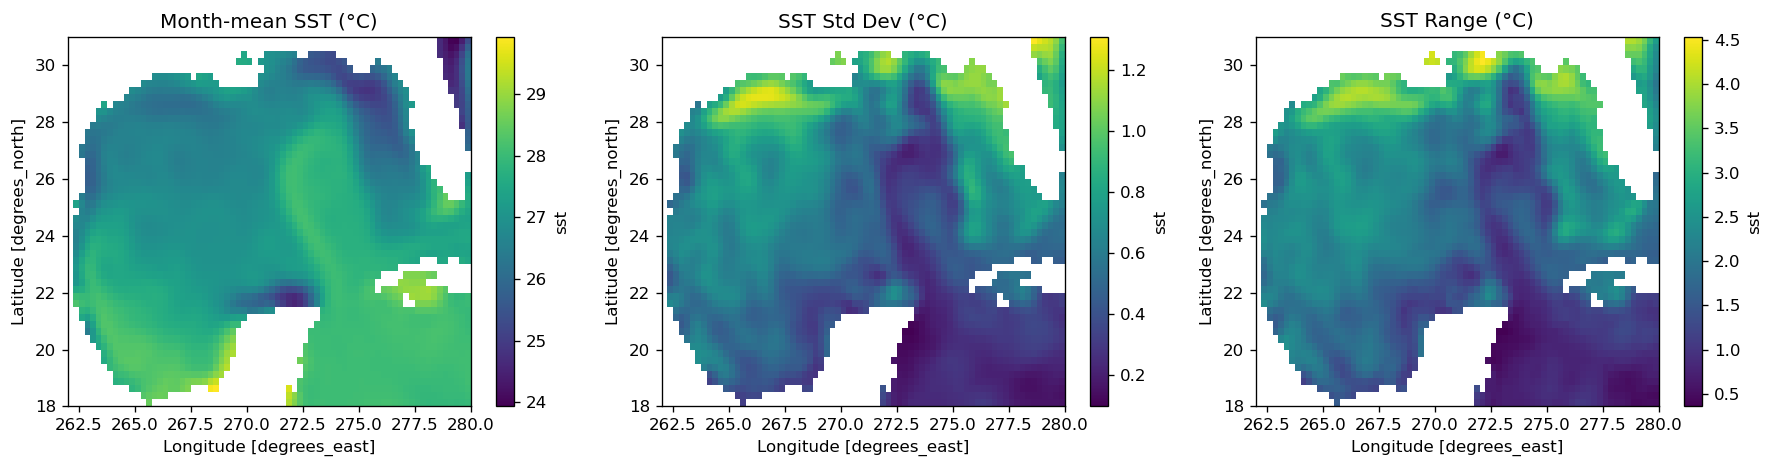

In [14]:
mean_sst = dss[var].mean('time')
std_sst  = dss[var].std('time')
range_sst = dss[var].max('time') - dss[var].min('time')

fig = plt.figure(figsize=(15,4))
ax = plt.subplot(1,3,1); mean_sst.plot(ax=ax); ax.set_title('Month-mean SST (°C)')
ax = plt.subplot(1,3,2); std_sst.plot(ax=ax); ax.set_title('SST Std Dev (°C)')
ax = plt.subplot(1,3,3); range_sst.plot(ax=ax); ax.set_title('SST Range (°C)')
plt.tight_layout(); plt.show()


## 6) Export a small subset for sharing (Check In Problem for Module 2)

Write a NetCDF with your regional mean time series and month-mean/variability maps.  Upload with your committed repository.

In [16]:
ds = xr.Dataset(
    data_vars={
        'region_mean_sst_timeseries': ts,
        'mean_sst_temporal': mean_sst,
        'std_sst_temporal': std_sst,
        'range_sst_temporal': range_sst
    }
)

file = 'sst_data.nc'
ds.to_netcdf(file)

In [17]:
with xr.open_dataset('sst_data.nc') as nc:
    print(nc)

<xarray.Dataset> Size: 46kB
Dimensions:                     (time: 31, zlev: 1, lat: 52, lon: 72)
Coordinates:
  * time                        (time) datetime64[ns] 248B 2022-05-01T12:00:0...
  * zlev                        (zlev) float32 4B 0.0
  * lat                         (lat) float32 208B 18.12 18.38 ... 30.62 30.88
  * lon                         (lon) float32 288B 262.1 262.4 ... 279.6 279.9
Data variables:
    region_mean_sst_timeseries  (time, zlev) float32 124B ...
    mean_sst_temporal           (zlev, lat, lon) float32 15kB ...
    std_sst_temporal            (zlev, lat, lon) float32 15kB ...
    range_sst_temporal          (zlev, lat, lon) float32 15kB ...
